# <center> Liver cirrhosis prediction </center>

## Table of content:
- [Problem and objectif presentation](attachment:./#introduction)
- [Load data frame](attachment:./#load-df)
- [Data infos](attachment:./#infos)
    - [Pandas profiling](attachment:./#pd-profiling)
- [Data cleaning](attachment:./#cleaning) 
    - [Replace Nan or Null values](attachment:./#nan)
    - [Define outliers](attachment:./#outliers)    
- [Data analysis](attachment:./#analysis)
- [Preprocessing data](attachment:./#preprocessing)
    - [Replace categorical data with integers](attachment:./#type)
    - [Features importance](attachment:./#features_importance)
    - [Define datasets](attachment:./#dataset)
        - regular with median value for numerical nan
            - with all data
            - without outliers
            - with k more explicative features:
                - k = [1-20]
        - regular with mean value for numerical nan
            - with all data
            - without outliers
            - with k more explicative features:
                - k = [1-20]
    - [Split Data](attachment:./#split)
- [Model](attachment:./#model)
- [Conclusion](attachment:./#conclusion)
- [References](attachment:./#references)

## Problem and objectif presentation: <a class="anchor" id="introduction"></a>
[source](https://towardsdatascience.com/5-data-science-projects-in-healthcare-that-will-get-you-hired-81003cadf2f3)

"Liver cirrhosis is a widespread problem especially in North America due to high intake of alcohol. In this project, we will predict liver cirrhosis in a patient based on certain lifestyle and health conditions of a patient.

Data set: This data set is available on [Kaggle](https://www.kaggle.com/fedesoriano/cirrhosis-prediction-dataset) which was collected from the Mayo Clinic trial.

This data set has about 20 features. These features are related to the patient’s details like age, sex, etc. and patient’s blood tests like prothrombin, triglycerides, platelets levels, etc. All these factors help in understanding a patient’s chances of liver cirrhosis.

The challenges for this dataset are the null values which need to either be replaced or deleted. Also, this data set has unbalanced classes, so it might require up-sampling the dataset."

The target feature is 'Stage' (1, 2, 3 or 4).

The dataset consists of following columns :

1. ID: unique identifier
2. N_Days: number of days between registration and the earlier of death, transplantation, or study analysis time in July 1986
3. Status: status of the patient C (censored), CL (censored due to liver tx), or D (death)
4. Drug: type of drug D-penicillamine or placebo
5. Age: age in [days]
6. Sex: M (male) or F (female)
7. Ascites: presence of ascites N (No) or Y (Yes)
8. Hepatomegaly: presence of hepatomegaly N (No) or Y (Yes)
9. Spiders: presence of spiders N (No) or Y (Yes)
10. Edema: presence of edema N (no edema and no diuretic therapy for edema), S (edema present without diuretics, or edema resolved by diuretics), or Y (edema despite diuretic therapy)
11. Bilirubin: serum bilirubin in [mg/dl]
12. Cholesterol: serum cholesterol in [mg/dl]
13. Albumin: albumin in [gm/dl]
14. Copper: urine copper in [ug/day]
15. Alk_Phos: alkaline phosphatase in [U/liter]
16. SGOT: SGOT in [U/ml]
17. Triglycerides: triglicerides in [mg/dl]
18. Platelets: platelets per cubic [ml/1000]
19. Prothrombin: prothrombin time in seconds [s]
20. Stage: histologic stage of disease (1, 2, 3, or 4)

In [29]:
!pip install pandas-profiling[notebook]

In [97]:
import pandas as pd
# from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

## Load Dataframe: <a class="anchor" id="load-df"></a>

In [60]:
def save_dataframe(_df, file_name='cirrhosis.csv'):
    _df.to_csv('data/processed/' + file_name, index=False)
    print('Dataframe {} saved in processed folder !'.format(file_name))
    return


def load_dataset(_raw, _processed, _data_name, _raw_data_name=None):
    """
    Load processed data if file doesn't exist else Copy a .csv
    file from raw data folder to processed data folder and load it.
    params:
    - raw_data_path: string, path to raw data
    - processed_data_path: string, path to processed data folder
    - data_filename: string, data name
    - verbose: bool,  to print dataset information
    return:
    - data: .csv data processed
    """
    if len(os.listdir(processed)) == 0:  # check if processed data file is empty
        shutil.copyfile(os.path.join(_raw, _raw_data_name), os.path.join(_processed, _data_name))
        print("Warning: no preprocess data, we copied raw data.")
    data_loaded = pd.read_csv(os.path.join(_processed, _data_name))
    print("Data '{}' loaded with data shape: {}".format(_data_name, data_loaded.shape))
    return data_loaded

In [61]:
raw = 'data/raw/'
processed = 'data/processed/'
df_name = 'cirrhosis.csv'
raw_data_name = df_name

df = load_dataset(raw, processed, df_name, _raw_data_name=raw_data_name)

Data 'cirrhosis.csv' loaded with data shape: (418, 20)


In [62]:
df_Nan_mean_name = 'Nan_mean_cirrhosis.csv'
df_cappe_outliers_name = 'cappe_outliers_cirrhosis.csv'

df_Nan_mean = load_dataset(raw, processed, df_Nan_mean_name)
df_cappe_outliers = load_dataset(raw, processed, df_cappe_outliers_name)

### Data infos: <a class="anchor" id="infos"></a>

In [63]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           312 non-null    object 
 4   Age            418 non-null    int64  
 5   Sex            418 non-null    object 
 6   Ascites        312 non-null    object 
 7   Hepatomegaly   312 non-null    object 
 8   Spiders        312 non-null    object 
 9   Edema          418 non-null    object 
 10  Bilirubin      418 non-null    float64
 11  Cholesterol    284 non-null    float64
 12  Albumin        418 non-null    float64
 13  Copper         310 non-null    float64
 14  Alk_Phos       312 non-null    float64
 15  SGOT           312 non-null    float64
 16  Tryglicerides  282 non-null    float64
 17  Platelets      407 non-null    float64
 18  Prothrombi

In [64]:
print(df.describe().T)

               count          mean          std      min         25%  \
ID             418.0    209.500000   120.810458     1.00    105.2500   
N_Days         418.0   1917.782297  1104.672992    41.00   1092.7500   
Age            418.0  18533.351675  3815.845055  9598.00  15644.5000   
Bilirubin      418.0      3.220813     4.407506     0.30      0.8000   
Cholesterol    284.0    369.510563   231.944545   120.00    249.5000   
Albumin        418.0      3.497440     0.424972     1.96      3.2425   
Copper         310.0     97.648387    85.613920     4.00     41.2500   
Alk_Phos       312.0   1982.655769  2140.388824   289.00    871.5000   
SGOT           312.0    122.556346    56.699525    26.35     80.6000   
Tryglicerides  282.0    124.702128    65.148639    33.00     84.2500   
Platelets      407.0    257.024570    98.325585    62.00    188.5000   
Prothrombin    416.0     10.731731     1.022000     9.00     10.0000   
Stage          412.0      3.024272     0.882042     1.00      2.

In [65]:
# convert age values from days to years:
df['Age'] = (df['Age'] / 365).astype('int64')

# drop 'ID' column:
df = df.drop('ID',axis=1)

In [66]:
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,D,D-penicillamine,58,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,C,D-penicillamine,56,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,D,D-penicillamine,70,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,D,D-penicillamine,54,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,1504,CL,Placebo,38,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


### Pandas profiling: <a class="anchor" id="pd-profiling"></a>

In [6]:
try:
    profile = ProfileReport(df, title = "Investigation avec Pandas Profiling", minimal=True)
    profile.to_notebook_iframe()
except NameError:
    print("You have not imported 'ProfileReport' module.")

You have not imported 'ProfileReport' module.


## Data cleaning:<a class="anchor" id="cleaning"></a>

1. replace nan values
2. define outliers

### Replace Nan or Null values: <a class="anchor" id="nan"></a>

In [67]:
def replace_numerical_nan_values(_df, median=True, mean=False):
    """
    Replace Nan or Null values with median or mean value for numerical columns.
    """
    _df_num_col = _df.select_dtypes(include=['int64', 'float64']).columns

    for _col in _df_num_col:
        if median:
            _df[_col].fillna(_df[_col].median(), inplace=True)
        elif mean:
            _df[_col].fillna(_df[_col].mean(), inplace=True)
        else:
            raise TypeError('At least one of the two values \'mean\' or \'median\' must be chosen !') 
    return _df


def replace_categorical_nan_values(_df, occurence=True):
    """
    Replace categorical null values by most occurence value in categorical column.
    """
    _df_cat_col = _df.select_dtypes(include='object').columns

    for _col in _df_cat_col:
        if occurence:
            _df[_col].fillna(_df[_col].mode().values[0], inplace=True)
        else:
            raise TypeError('You must choose a strategy to replace null categorical values')
    return _df

In [68]:
# Checking for missing values:
print(df.isnull().sum())

N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64


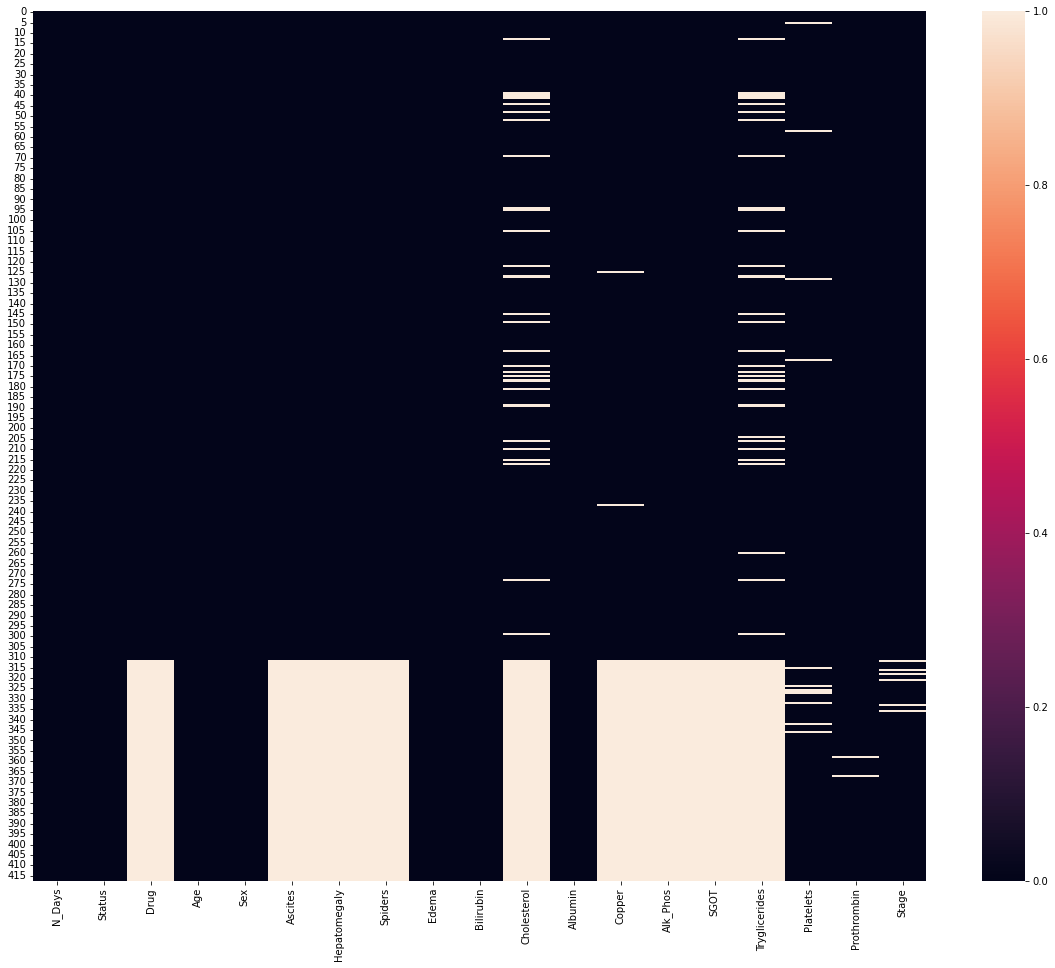

In [69]:
# checking for missing values repartition:
plt.figure(figsize = (20, 16))
sns.heatmap(df.isnull())

#### Handling missing values:

[source](https://www.kaggle.com/arjunbhaybhang/liver-cirrhosis-prediction-with-xgboost-eda)

"This is a problem, we could just get rid of all examples with NA values, but in this case our case of small dataset we cannot afford that.

We will impute the missing entries with some statistical calculations.


We have two different types of data

1) Numerical data ( Age, Cholesterol, Platelets.. etc)
2) Categorical Data ( Drug, Sex, Spiders..etc)

We will have to use different imputation for each type

1) For the numerical type we can use mean or median. In this case we will go with median to avoid skewing in the presence of outliers
2) For Categorical type we will impute the most frequent class.
" 

In [70]:
# for numerical type:
print(df.select_dtypes(include=['int64', 'float64']).isna().sum())

N_Days             0
Age                0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64


In [71]:
# for categorical type:
print(df.select_dtypes(include='object').isna().sum())

Status            0
Drug            106
Sex               0
Ascites         106
Hepatomegaly    106
Spiders         106
Edema             0
dtype: int64


In [72]:
# define a new dataset to replace nan numerical values by mean:
df_Nan_mean = df.copy()

# replace nan numerical values:
df = replace_numerical_nan_values(df)
df = replace_categorical_nan_values(df)

# replace nan categorical values:
df_Nan_mean = replace_numerical_nan_values(df_Nan_mean, median=False, mean=True)
df_Nan_mean = replace_categorical_nan_values(df_Nan_mean)

In [73]:
print(df.select_dtypes(include=['int64', 'float64']).isna().sum())
print(df.select_dtypes(include='object').isna().sum())

N_Days           0
Age              0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64
Status          0
Drug            0
Sex             0
Ascites         0
Hepatomegaly    0
Spiders         0
Edema           0
dtype: int64


In [74]:
print(df_Nan_mean.select_dtypes(include=['int64', 'float64']).isna().sum())
print(df_Nan_mean.select_dtypes(include='object').isna().sum())

N_Days           0
Age              0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64
Status          0
Drug            0
Sex             0
Ascites         0
Hepatomegaly    0
Spiders         0
Edema           0
dtype: int64


### Define outliers: <a class="anchor" id="outliers"></a>
 
"Outliers can be checked by calculating the z-score of the dataset and keeping a threshold value beyond which the data values will be considered outliers."

Note: obviously, outliers concerned only numerical values...

1. Detect outliers: boxplot, Z-score, IQR.
2. Handle outliers: drop, capping outliers, replace by median?

Here, I decide to test to create a new dataset with outliers handled.
In order to detect outliers, I choose IQR and I decide to capping it by min or max.

In [76]:
# Age is well distributed and N_days not contains outliers notable:
outliers_columns_list = df.select_dtypes(include=['int64', 'float64']).columns.drop(['Stage', 'Age', 'N_Days'])
outliers_columns_list

Index(['Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT',
       'Tryglicerides', 'Platelets', 'Prothrombin'],
      dtype='object')

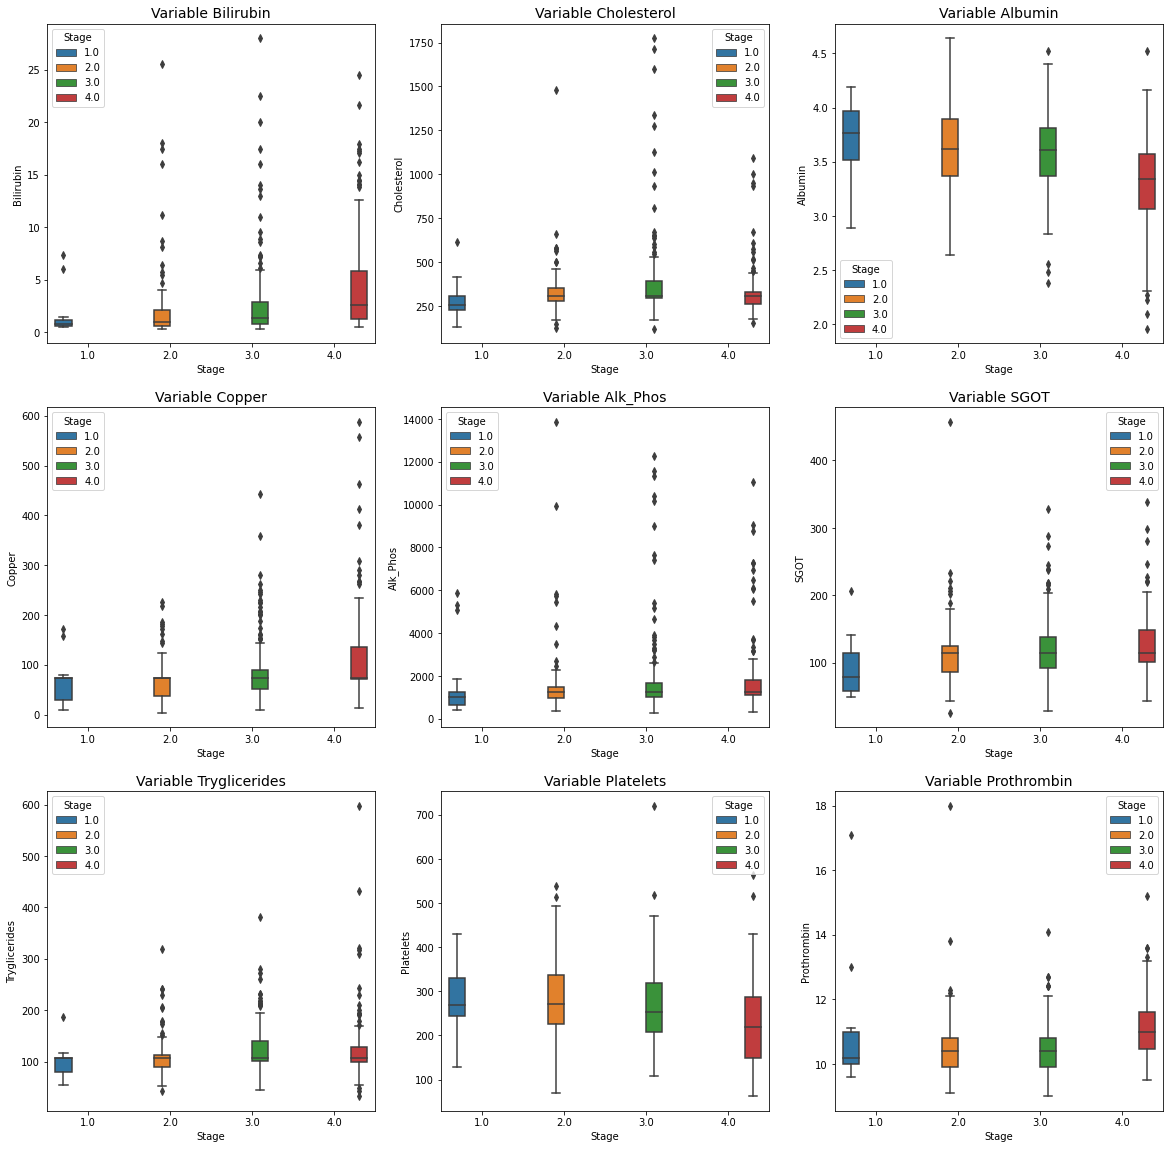

In [77]:
fig, axs = plt.subplots(3, 3, figsize = (20, 20))
axs = axs.flat

for i, column in enumerate(outliers_columns_list):
    sns.boxplot(data=df, x="Stage", y=column, hue="Stage", ax=axs[i], palette="tab10")
    axs[i].set_title(f"Variable {column}", fontsize=14)

In [79]:
def remove_outliers(_df, column_list):
    for _col in column_list:
        q1 = np.quantile(_df[_col], 0.25)
        q3 = np.quantile(_df[_col], 0.75)
        iqr = q3 - q1
        
        _max = q3 + 1.5 * iqr
        _min = q1 - 1.5 * iqr
        
        _df.loc[df[_col] > _max, _col] = _max
        _df.loc[df[_col] < _min, _col] = _min
    return _df

In [80]:
df_cappe_outliers = df.copy()
df_cappe_outliers = remove_outliers(df_cappe_outliers, outliers_columns_list)

In [81]:
df_cappe_outliers.describe().T

,count,mean,std,min,25%,50%,75%,max
N_Days,418.0,1917.782297,1104.672992,41.00000,1092.7500,1730.00,2613.50,4795.00000
Age,418.0,50.382775,10.481084,26.00000,42.0000,51.00,58.00,78.00000
Bilirubin,418.0,2.492344,2.296591,0.30000,0.8000,1.40,3.40,7.30000
Cholesterol,418.0,318.137859,75.067557,160.87500,273.0000,309.50,347.75,459.87500
Albumin,418.0,3.501080,0.413492,2.45125,3.2425,3.53,3.77,4.56125
Copper,418.0,81.930622,45.909801,4.00000,51.2500,73.00,100.75,175.00000
Alk_Phos,418.0,1420.732057,638.326300,289.00000,1016.2500,1259.00,1707.75,2745.00000
SGOT,418.0,117.749545,40.147386,26.35000,91.0000,114.70,135.75,202.87500
Tryglicerides,418.0,112.911782,33.235903,45.87500,95.0000,108.00,127.75,176.87500
Platelets,418.0,256.029904,94.199467,62.00000,190.0000,251.00,315.50,503.75000


In [82]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
N_Days,418.0,1917.782297,1104.672992,41.00,1092.7500,1730.00,2613.50,4795.00
Age,418.0,50.382775,10.481084,26.00,42.0000,51.00,58.00,78.00
Bilirubin,418.0,3.220813,4.407506,0.30,0.8000,1.40,3.40,28.00
Cholesterol,418.0,350.272727,193.123893,120.00,273.0000,309.50,347.75,1775.00
Albumin,418.0,3.497440,0.424972,1.96,3.2425,3.53,3.77,4.64
Copper,418.0,91.279904,74.485481,4.00,51.2500,73.00,100.75,588.00
Alk_Phos,418.0,1799.144976,1875.121982,289.00,1016.2500,1259.00,1707.75,13862.40
SGOT,418.0,120.564067,49.085094,26.35,91.0000,114.70,135.75,457.25
Tryglicerides,418.0,119.267943,54.050691,33.00,95.0000,108.00,127.75,598.00
Platelets,418.0,256.866029,97.024861,62.00,190.0000,251.00,315.50,721.00


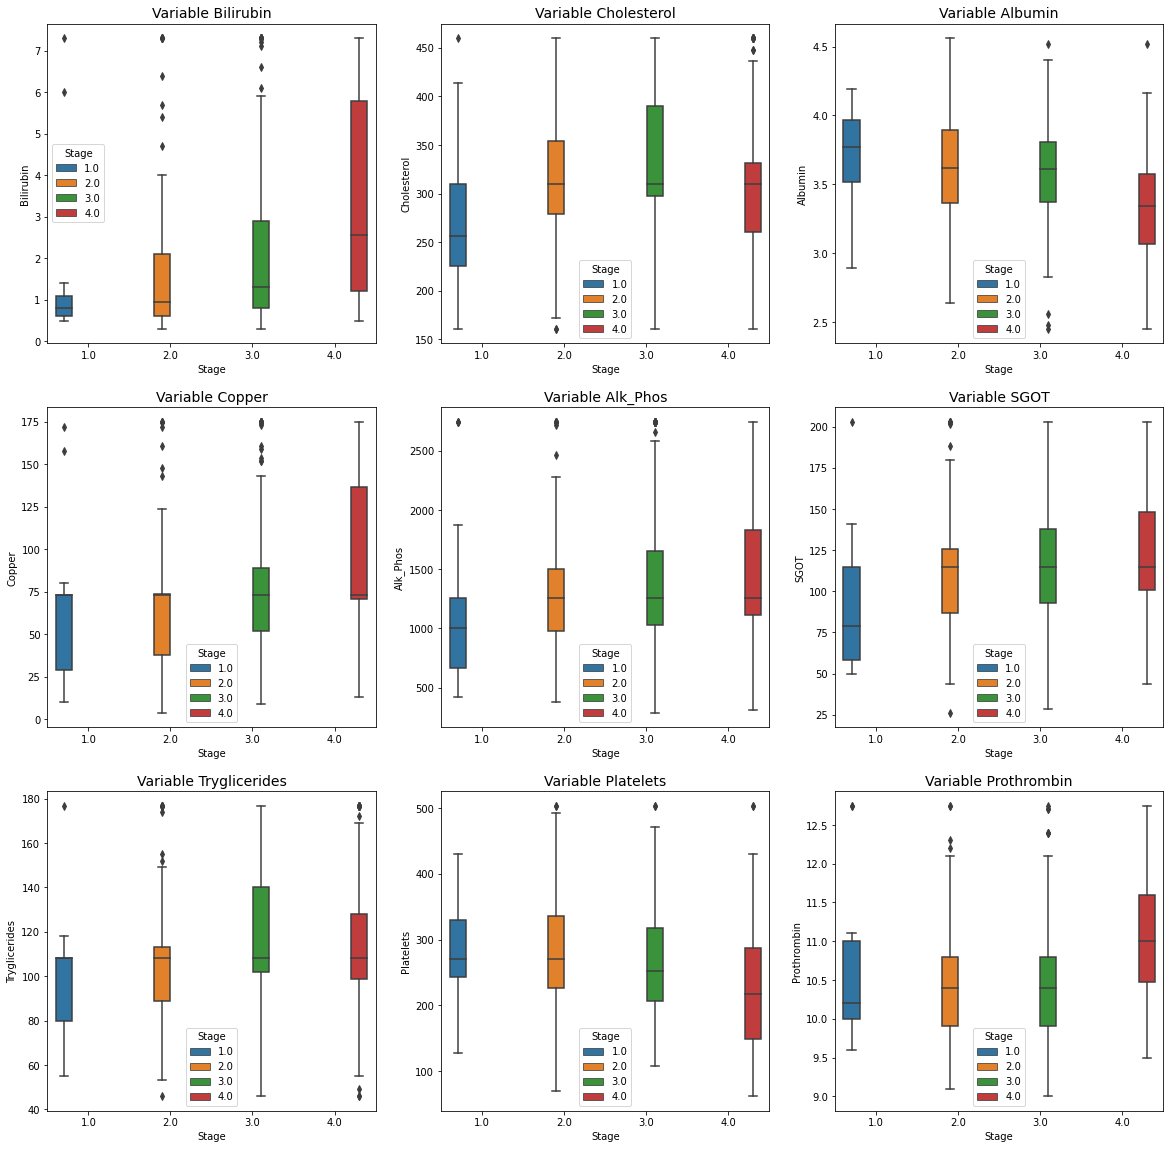

In [83]:
fig, axs = plt.subplots(3, 3, figsize = (20, 20))
axs = axs.flat

for i, column in enumerate(outliers_columns_list):
    sns.boxplot(data=df_cappe_outliers, x="Stage", y=column, hue="Stage", ax=axs[i], palette="tab10")
    axs[i].set_title(f"Variable {column}", fontsize=14)

In [84]:
# save datasets:
save_dataframe(df)
save_dataframe(df_Nan_mean, 'Nan_mean_cirrhosis.csv')
save_dataframe(df_cappe_outliers, 'cappe_outliers_cirrhosis.csv')

Dataframe cirrhosis.csv saved in processed folder !
Dataframe Nan_mean_cirrhosis.csv saved in processed folder !
Dataframe cappe_outliers_cirrhosis.csv saved in processed folder !


## Data analysis: <a class="anchor" id="analysis"></a>

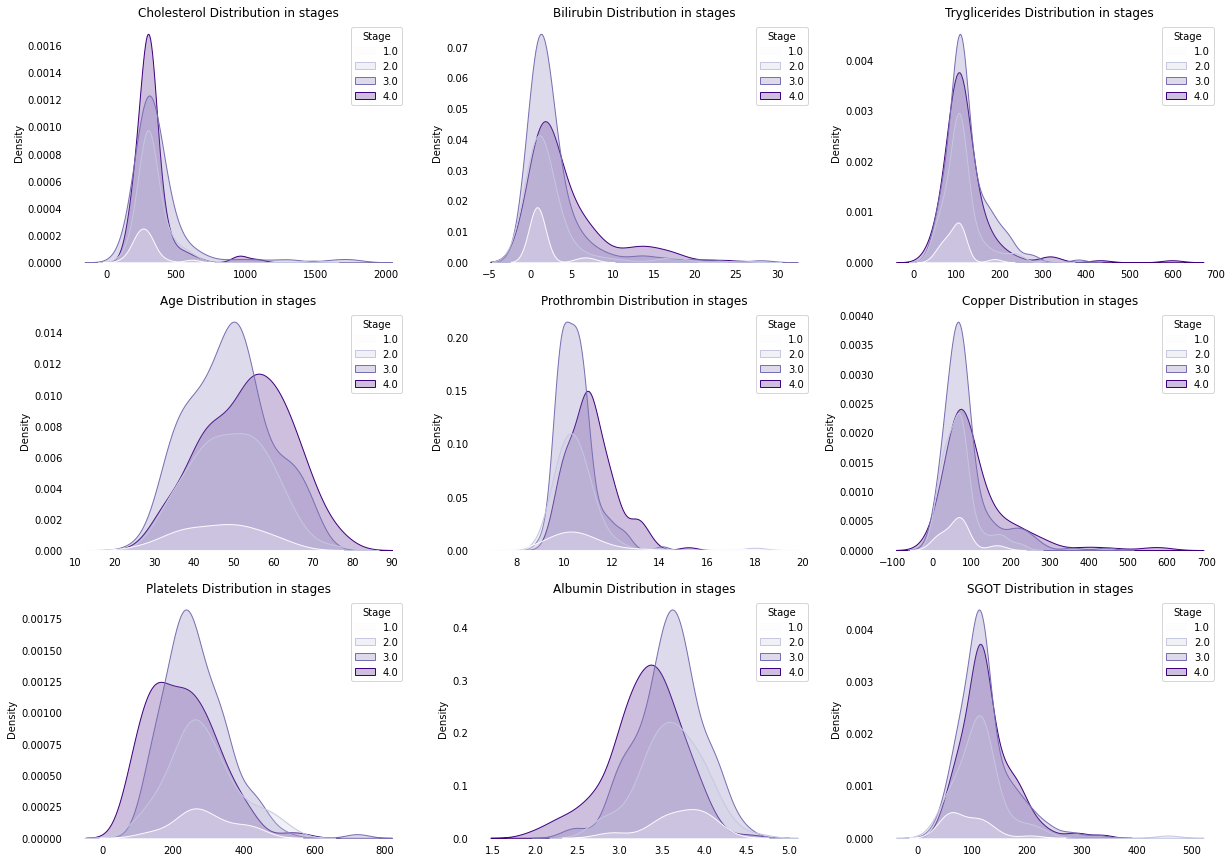

In [85]:
# Distribution Polts

feature_list = ['Cholesterol', 'Bilirubin', 'Tryglicerides', 'Age', 'Prothrombin', 'Copper', 'Platelets', 'Albumin', 'SGOT']

plt.figure(figsize=(20.6,15))

for i, feat in enumerate(feature_list):
    plt.subplot(3,3,i+1)
    sns.kdeplot(df[feat], hue=df['Stage'], fill=True, palette='Purples')
    sns.despine(top=True, right=True, bottom=True, left=True)
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
    plt.xlabel('')
    plt.title('{} Distribution in stages'.format(feat))

plt.show()

"Looking at the feature distribution we can observe that in features such as Age, Prothrombin, Copper the risk of the disease increase with increase in feature value, thus having a positive co-relation on with the disease probability. Lets fit a regression line to check."

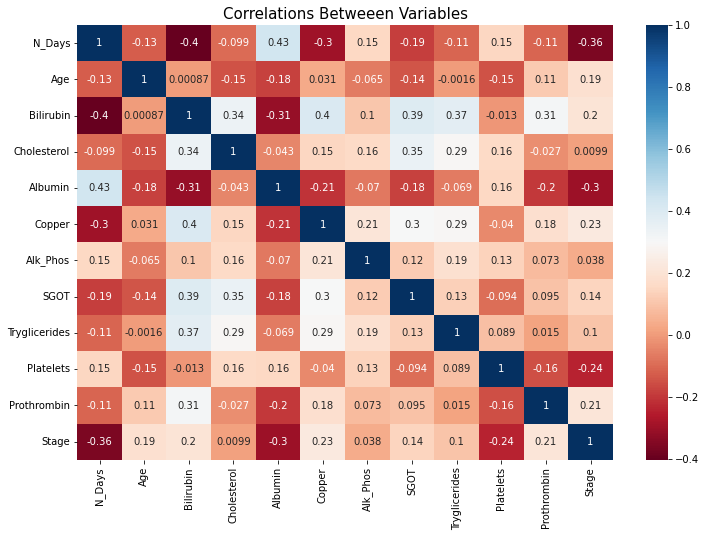

In [86]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap="RdBu")
plt.title("Correlations Betweeen Variables", size=15)
plt.show()

## Preprocessing data:  <a class="anchor" id="preprocessing"></a>

### Replace categorical data with integers: <a class="anchor" id="type"></a>

In [87]:
def categorical_to_integers_type(_df):
    _df['Sex'] = _df['Sex'].replace({'M':0, 'F':1})                                # Male : 0 , Female :1
    _df['Ascites'] = _df['Ascites'].replace({'N':0, 'Y':1})                        # N : 0, Y : 1   
    _df['Drug'] = _df['Drug'].replace({'D-penicillamine':0, 'Placebo':1})          # D-penicillamine : 0, Placebo : 1   
    _df['Hepatomegaly'] = _df['Hepatomegaly'].replace({'N':0, 'Y':1})              # N : 0, Y : 1
    _df['Spiders'] = _df['Spiders'].replace({'N':0, 'Y':1})                        # N : 0, Y : 1
    _df['Edema'] = _df['Edema'].replace({'N':0, 'Y':1, 'S':2})                    # N : 0, Y : 1, S : 2
    _df['Status'] = _df['Status'].replace({'C':0, 'CL':1, 'D':2})                 # 'C':0, 'CL':1, 'D':2
    return _df

In [88]:
df = categorical_to_integers_type(df)
df_Nan_mean = categorical_to_integers_type(df_Nan_mean)
df_cappe_outliers = categorical_to_integers_type(df_cappe_outliers)

### Features importance: <a class="anchor" id="features_importance"></a>

We will not be using 'Status' and 'N_days' as our features since this will cause data Leakage.

In [90]:
# Setting up Features and Target

def set_feature_and_target(_df):
    X = _df.drop(['Status', 'N_Days', 'Stage'], axis=1)
    y = _df.pop('Stage')
    print(X.shape, y.shape)
    return X, y

X, y = set_feature_and_target(df)
X_Nan_mean, y_Nan_mean = set_feature_and_target(df_Nan_mean)
X_cappe_outliers, y_cappe_outliers = set_feature_and_target(df_cappe_outliers)

(418, 16) (418,)
(418, 16) (418,)
(418, 16) (418,)


### Split Data: <a class="anchor" id="split"></a>

In [0]:
def training(train, test, train_index, test_index, _y, fold_no, _model):
  X_train = train
  y_train = _y.iloc[train_index]
  X_test = test
  y_test = _y.iloc[test_index]
  _model.fit(X_train, y_train)
  score = _model.score(X_test,y_test)
  return score
   
def loop_skf_train(_skf, _X, _y, _model):
    acc=[]
    fold_no = 1
    for train_index, test_index in _skf.split(_X, _y):
        train = _X.iloc[train_index,:]
        test = _X.iloc[test_index,:]
        score = training(train, test, train_index, test_index, _y, fold_no, _model)
        acc.append(score)
        print('For Fold {} the accuracy is {}'.format(str(fold_no),score))
        fold_no += 1
    print('Logestic Regression Mean Accuracy = ', np.mean(acc))
    return

## Model: <a class="anchor" id="model"></a>

Earlier while examining the distribution of target in the data, we found that the data is unevenly distributed, that is there are more examples of a certain class than other.

To tackel this imbalance we will use Stratified k-Fold Cross Validation.

In [89]:
x = df.drop('Stage',axis=1)
y = df['Stage']

ordered_rank_features = SelectKBest(score_func=chi2, k=15)
ordered_feature = ordered_rank_features.fit(x,y)

dfscores = pd.DataFrame(ordered_feature.scores_, columns=["Score"])
dfcolumns = pd.DataFrame(x.columns)

features_rank = pd.concat([dfcolumns, dfscores], axis=1)
features_rank.columns = ['Features', 'Score']
# print(features_rank)

print(features_rank.nlargest(15, 'Score'))

         Features         Score
0          N_Days  35750.464537
13       Alk_Phos   1997.359972
12         Copper   1450.366134
10    Cholesterol   1072.235092
16      Platelets    966.519338
14           SGOT    213.097727
15  Tryglicerides    163.716890
9       Bilirubin    112.325984
1          Status     50.258911
3             Age     41.551884
8           Edema     31.020151
5         Ascites     30.203966
7         Spiders     20.905743
6    Hepatomegaly     20.280409
17    Prothrombin      3.639922


In [114]:
skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

### Logistic Regression:

In [115]:
log_model = LogisticRegression(max_iter=5000, solver='saga')

In [116]:
loop_skf_train(skf, X, y, log_model)

For Fold 1 the accuracy is 0.5476190476190477
For Fold 2 the accuracy is 0.7142857142857143
For Fold 3 the accuracy is 0.42857142857142855
For Fold 4 the accuracy is 0.35714285714285715
For Fold 5 the accuracy is 0.47619047619047616
For Fold 6 the accuracy is 0.4523809523809524
For Fold 7 the accuracy is 0.5238095238095238
For Fold 8 the accuracy is 0.4523809523809524
For Fold 9 the accuracy is 0.3902439024390244
For Fold 10 the accuracy is 0.43902439024390244
Logestic Regression Mean Accuracy =  0.47816492450638803


### XGboost:

In [117]:
xgboost_model = XGBClassifier(learning_rate=0.75, max_depth=3, random_state=1, gamma=0, eval_metric='error') # tried learning rate values between range [0.01 - 10] & depth [2-8]

In [118]:
loop_skf_train(skf, X, y, xgboost_model)

For Fold 1 the accuracy is 0.5238095238095238
For Fold 2 the accuracy is 0.5714285714285714
For Fold 3 the accuracy is 0.47619047619047616
For Fold 4 the accuracy is 0.35714285714285715
For Fold 5 the accuracy is 0.5952380952380952
For Fold 6 the accuracy is 0.47619047619047616
For Fold 7 the accuracy is 0.5
For Fold 8 the accuracy is 0.5476190476190477
For Fold 9 the accuracy is 0.4146341463414634
For Fold 10 the accuracy is 0.5121951219512195
Logestic Regression Mean Accuracy =  0.49744483159117314


/opt/python/envs/default/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/python/envs/default/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/python/envs/default/lib/python3.8/site-packages/xgboost/sklearn.py:

In [119]:
XGB_model_predict = xgboost_model.predict(test)
XGB_model_predict_proba = xgboost_model.predict_proba(test)

print(classification_report(y.iloc[test_index], XGB_model_predict))

              precision    recall  f1-score   support

         1.0       0.50      0.50      0.50         2
         2.0       0.60      0.33      0.43         9
         3.0       0.50      0.56      0.53        16
         4.0       0.50      0.57      0.53        14

    accuracy                           0.51        41
   macro avg       0.53      0.49      0.50        41
weighted avg       0.52      0.51      0.51        41



## Conclusion: <a class="anchor" id="conclusion"></a>

## References: <a class="anchor" id="references"></a>
- [towardsdatascience](https://towardsdatascience.com/5-data-science-projects-in-healthcare-that-will-get-you-hired-81003cadf2f3)
- [Kaggle: Arjun Bhaybhang](https://www.kaggle.com/arjunbhaybhang/liver-cirrhosis-prediction-with-xgboost-eda)